<a href="https://colab.research.google.com/github/Deathvanos/MPA_MLF-Classification_5G_base_stations/blob/main/MLF_MPA_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr>
<center>
    <h1></h1>
    <h1>MPA-MLF - Final project - ISEP</h1>
    <h3>Classification 5G base stations</h3>
    <h7>Guillaume Cappe de Baillon - Charles Mailley</h7>
</center>
<hr>

In [1]:
# Google Drive connexion
from google.colab import drive
drive.mount('drive')
import os

path_list = ["drive/MyDrive/ISEP/VUT_BUT_BRNO/Machine_Learning",
             "drive/MyDrive/BRNO/ML_Project",
             ]
path = None
for path in path_list:
    if os.path.exists(path):
        path = path
        print(path)
        break
    else:
        continue
if path is None:
    raise Exception("Path not found. Please add yours in the path_list. Use 'os.listdir()")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
drive/MyDrive/ISEP/VUT_BUT_BRNO/Machine_Learning


In [2]:
import os
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Functions

In [3]:
def display_npy_images(ids, dico):
    plt.figure(figsize=(5 * len(ids), 5))
    for i, img_id in enumerate(ids):
        if isinstance(dico, dict):
            img = dico.get(str(img_id))
        elif isinstance(dico, np.ndarray):
            img = dico[img_id]
        else:
            img = None
        if img is None:
            print(f"Sample  {img_id} not in the dict.")
        plt.subplot(1, len(ids), i + 1)
        plt.imshow(img,)
        plt.title(f"Sample {img_id}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def preprocess_data(data_dict: Dict[str, np.ndarray], df_label: pd.DataFrame, logging:bool=False):
    global IMG_HEIGHT, IMG_WIDTH

    # Sort image IDs numerically
    sorted_ids = sorted([int(k) for k in data_dict.keys()])
    sorted_ids_str = [str(i) for i in sorted_ids]

    # Stack images in sorted order
    X_list = [data_dict[id_str] for id_str in sorted_ids_str]
    X_full = np.array(X_list)

    # Merge to align labels with sorted image IDs
    df_ids = pd.DataFrame({'ID': sorted_ids})
    df_merged = df_ids.merge(df_label, on='ID', how='inner')
    y_full = df_merged['target'].values
    num_classes = len(np.unique(y_full))

    # Sanity check
    if X_full.shape[0] != y_full.shape[0]:
        raise ValueError(f"Mismatch: {X_full.shape[0]} images vs {y_full.shape[0]} labels")

    # Normalize to [0, 1]
    X_full = X_full.astype('float32') / 255.0

    # Add channel dimension for CNNs
    IMG_HEIGHT, IMG_WIDTH = X_full.shape[1], X_full.shape[2]
    X_full = X_full.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

    # Logging
    if logging:
        print(f"Prepared data set: X shape = {X_full.shape}, y shape = {y_full.shape}")
        print("Class distribution:")
        print(pd.Series(y_full).value_counts().sort_index())
        print(f"Number of classes: {num_classes}")
    return X_full, y_full, num_classes

In [5]:
def augment_batch_with_balancing(images, labels_original, labels_onehot, batch_size=32, augment=True):
    """
    Custom function to create optionally augmented batches with class balancing.
    Ensures roughly equal representation of classes per batch via oversampling.
    """
    n_samples = len(images)
    unique_classes = np.unique(labels_original)
    num_classes_gen = len(unique_classes)

    if num_classes_gen == 0: # Handle empty input case
        print("Warning: No classes found in labels provided to generator.")
        while True: yield np.array([]), np.array([])

    # Get indices for each class
    class_indices = {cls: np.where(labels_original == cls)[0] for cls in unique_classes}

    # Determine number of samples per class per batch
    samples_per_class = batch_size // num_classes_gen if num_classes_gen > 0 else 0
    remainder = batch_size % num_classes_gen if num_classes_gen > 0 else batch_size

    while True:
        batch_indices = []
        # Add base samples per class
        for cls in unique_classes:
            if len(class_indices.get(cls, [])) > 0: # Check if class has samples and key exists
                batch_indices.extend(np.random.choice(class_indices[cls], size=samples_per_class, replace=True))

        # Distribute remaining samples randomly among classes that have samples
        available_classes = [cls for cls in unique_classes if len(class_indices.get(cls, [])) > 0]
        if remainder > 0 and available_classes:
             extra_classes = np.random.choice(available_classes, size=remainder, replace=True)
             for cls in extra_classes:
                  batch_indices.extend(np.random.choice(class_indices[cls], size=1, replace=True))

        # Shuffle the selected batch indices
        np.random.shuffle(batch_indices)

        # Ensure batch size is correct
        batch_indices = batch_indices[:batch_size]
        while len(batch_indices) < batch_size and n_samples > 0:
             pad_idx = np.random.choice(n_samples, 1)[0]
             batch_indices.append(pad_idx)

        if not batch_indices: # If still no indices (e.g., n_samples=0)
            if n_samples == 0: yield np.array([]), np.array([]); continue
            else: print("Warning: Generated empty batch_indices unexpectedly."); continue

        # Get the images and one-hot labels for the selected indices
        batch_images = images[batch_indices].copy()
        batch_labels = labels_onehot[batch_indices].copy() # Yield one-hot labels

        if augment:
            # Apply random transformations
            for i in range(len(batch_images)):
                if np.random.random() > 0.5: # Random horizontal flip
                    img = batch_images[i].squeeze() # Remove channel dim for flip
                    img = np.fliplr(img)
                    batch_images[i, :, :, 0] = img # Add channel dim back
                # Random brightness adjustment
                brightness_factor = 0.8 + 0.4 * np.random.random()
                batch_images[i] = np.clip(batch_images[i] * brightness_factor, 0, 1)

        yield batch_images, batch_labels

In [6]:
def evaluate_model(model, history, X_eval, y_eval):
    """
    Evaluate the model performance and plot loss/accuracy curves.
    Uses the provided evaluation set (e.g., validation or test).
    """
    print("\n--- Evaluating Model ---")
    score = model.evaluate(X_eval, y_eval, verbose=0)
    print(f"Evaluation Loss: {score[0]:.4f}")
    print(f"Evaluation Accuracy: {score[1]*100:.2f}%")

    # Plot curves
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    return score

In [7]:
def plot_confusion_matrix_and_report(model, X_eval, y_eval_onehot, class_labels=None):
    """
    Generate predictions, plot confusion matrix, and print classification report
    on the provided evaluation set.
    """
    print("\n--- Generating Predictions and Reports ---")
    if class_labels is None:
        num_classes_rep = y_eval_onehot.shape[1]
        class_labels = [str(i) for i in range(num_classes_rep)]

    # Predictions
    y_pred = model.predict(X_eval)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_eval_onehot, axis=1)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    # Ensure target_names match the number of classes
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels, zero_division=0))
    return conf_matrix

# Data Importation

In [8]:
df_label_train_orig = pd.read_csv(f'{path}/data/label_train.csv')
folder_train = f'{path}/data/Train'
train_data_dict = {file[:-4]: np.load(f'{folder_train}/{file}') for file in os.listdir(folder_train)}

# Data Exploration

Number of element in class 0 -> 1209 samples


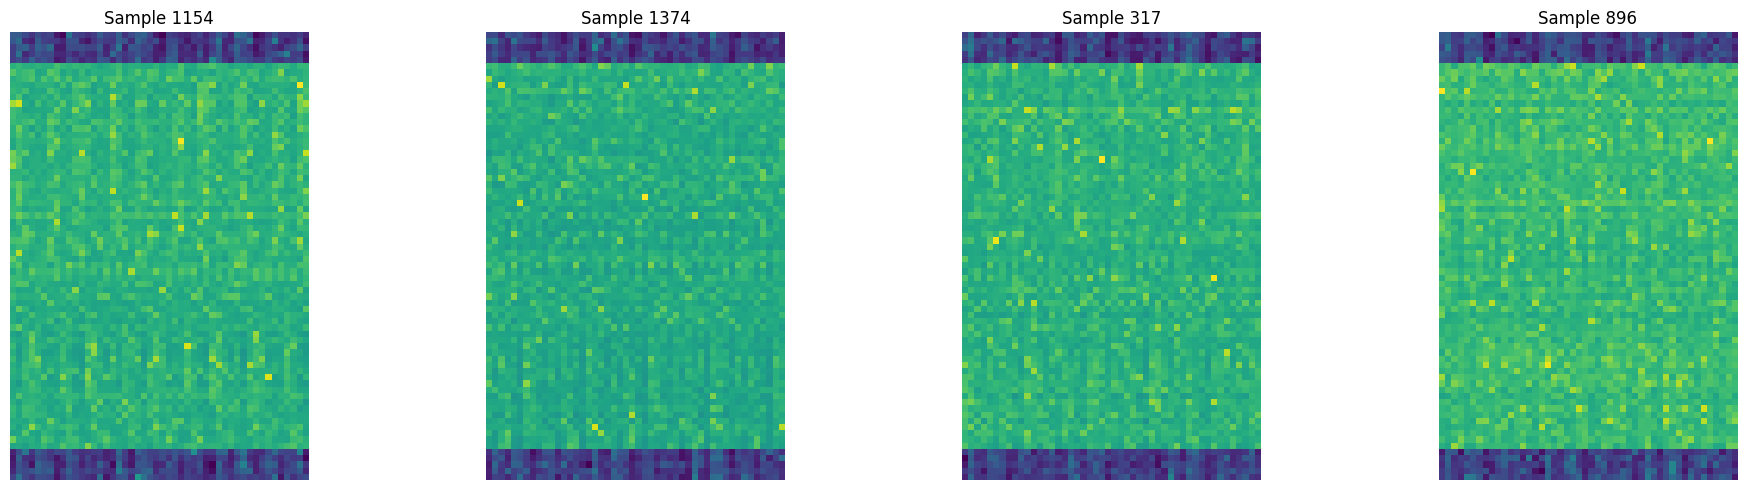

In [9]:
# Print random images by class
class_number = 0
image_number = 4
id_list = df_label_train_orig.query(f"target == {class_number}")['ID'].to_list()
print(f"Number of element in class {class_number} -> {len(id_list)} samples")
id_list = random.sample(id_list, image_number)
display_npy_images(id_list, train_data_dict)

Dataset size: 1491
Image size: (72, 48)
Image value: [[-41.62057654 -34.16925014 -37.51496645 ... -35.41163519 -38.76794303
  -43.23367034]
 [-45.06022426 -27.55944375 -42.01593262 ... -45.57866327 -43.60281041
  -38.01163686]
 [-40.23451665 -33.07184719 -47.47832433 ... -42.82648219 -38.99605899
  -50.46283493]
 ...
 [-58.65746832 -35.20950318 -35.60084405 ... -45.40996766 -37.96642037
  -49.81003511]
 [-58.18925173 -26.99947696 -45.84695149 ... -45.27875628 -25.47920344
  -54.08462235]
 [-52.26813165 -24.21840925 -36.25716251 ... -42.12282432 -29.37762935
  -47.21588863]]


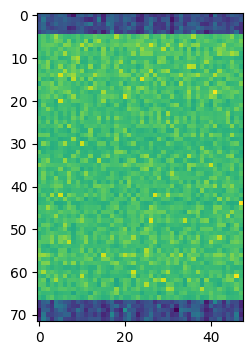

In [10]:
# Image dataset exporation
index = "3"
np_image = train_data_dict[index]
print(f"Dataset size: {len(train_data_dict)}")
print(f"Image size: {np_image.shape}")
print(f"Image value: {np_image}")
plt.figure(figsize=(4,4))
plt.imshow(np_image)

In [11]:
# Explore label_train.csv
print(df_label_train_orig.info())
print(f"\nDataframe shape: {df_label_train_orig.shape}")
print(f"Class list: {df_label_train_orig['target'].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491 entries, 0 to 1490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      1491 non-null   int64
 1   target  1491 non-null   int64
dtypes: int64(2)
memory usage: 23.4 KB
None

Dataframe shape: (1491, 2)
Class list: [0 2 1]


# Data preprocessing

In [12]:
IMG_HEIGHT, IMG_WIDTH = None, None # image.size
VAL_SIZE = 0.2 # train_test_split.test_size
MODELE_NAME = "best_model.keras" #

In [13]:
X_train_full, y_train_full, num_classes = preprocess_data(train_data_dict, df_label_train_orig, logging=True)

Prepared data set: X shape = (1491, 72, 48, 1), y shape = (1491,)
Class distribution:
0    1209
1     141
2     141
Name: count, dtype: int64
Number of classes: 3


In [33]:
# Split data into train and validation sets
X_train, X_val, y_train_labels, y_val_labels = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_SIZE,
    stratify=y_train_full # Crucial for imbalance
)

# One-hot encoding
y_train = to_categorical(y_train_labels, num_classes)
y_val = to_categorical(y_val_labels, num_classes)

# Logging
print("Data Split Shapes")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train (one-hot) shape:", y_train.shape)
print("y_val (one-hot) shape:", y_val.shape)
print("\nClass distribution in TRAINING set:")
print(pd.Series(y_train_labels).value_counts().sort_index())
print("\nClass distribution in VALIDATION set:")
print(pd.Series(y_val_labels).value_counts().sort_index())

Data Split Shapes
X_train shape: (1192, 72, 48, 1)
X_val shape: (299, 72, 48, 1)
y_train (one-hot) shape: (1192, 3)
y_val (one-hot) shape: (299, 3)

Class distribution in TRAINING set:
0    966
1    113
2    113
Name: count, dtype: int64

Class distribution in VALIDATION set:
0    243
1     28
2     28
Name: count, dtype: int64


# Model Creation

In [34]:
# Define the CNN model
model = Sequential(name="Chagui_Team_model")

# Input layer
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
# First convolutional
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Second convolutional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Fully connected dense layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of the model
model.summary()

Model: "Chagui_Team_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 70, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 35, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 33, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,051 (5.07 MB)

 Trainable params: 1,330,051 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Create the balanced generator
balanced_train_generator = augment_batch_with_balancing(
    X_train,
    y_train_labels, # Original labels for balancing
    y_train,        # One-hot labels for model output
    batch_size=32,
    augment=False
)

# Calculate steps per epoch
steps_per_epoch = len(X_train) // 32
if steps_per_epoch == 0: steps_per_epoch = 1

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(MODELE_NAME, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
]

# Model training
history = model.fit(
    balanced_train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7794 - loss: 0.6719
Epoch 1: val_accuracy improved from -inf to 0.88294, saving model to best_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.7802 - loss: 0.6693 - val_accuracy: 0.8829 - val_loss: 0.4220
Epoch 2/50
28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8685 - loss: 0.4598
Epoch 2: val_accuracy improved from 0.88294 to 0.88629, saving model to best_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8729 - loss: 0.4432 - val_accuracy: 0.8863 - val_loss: 0.3635
Epoch 3/50
33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8908 - loss: 0.3125
Epoch 3: val_accuracy improved from 0.88629 to 0.93645, saving model to best_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8914 - loss: 0.3067 - val_accuracy: 0.9365 - val_loss: 0.2041
Epoch 4/50
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9334 - loss: 0.2189
Epoch 4: val_accuracy improved from 0.93645 to 0.98


Loaded best weights for Model evaluation.

--- Evaluating Model ---
Evaluation Loss: 0.0444
Evaluation Accuracy: 99.33%


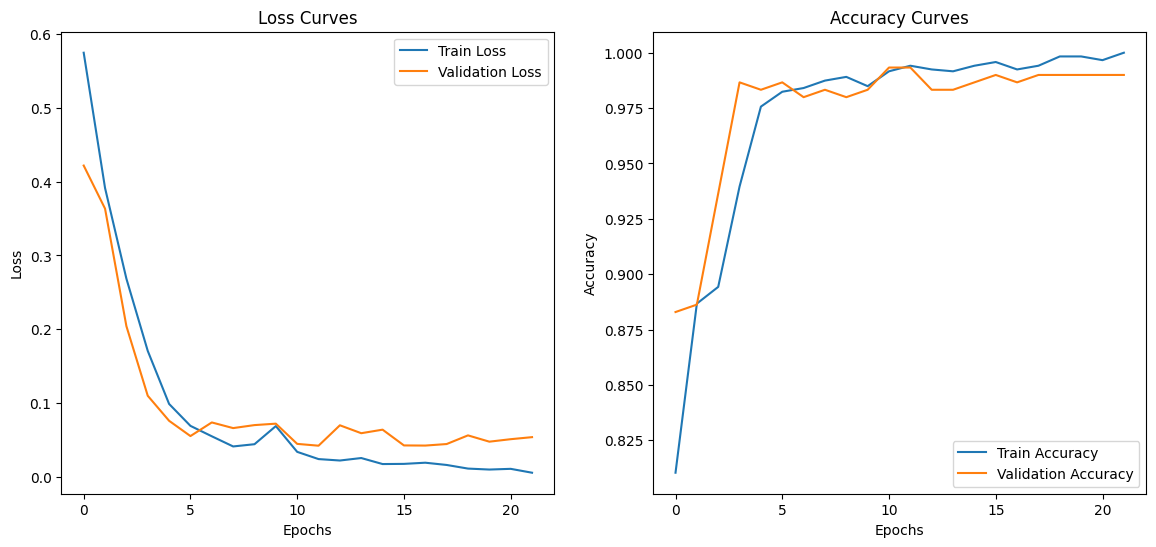


--- Generating Predictions and Reports ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


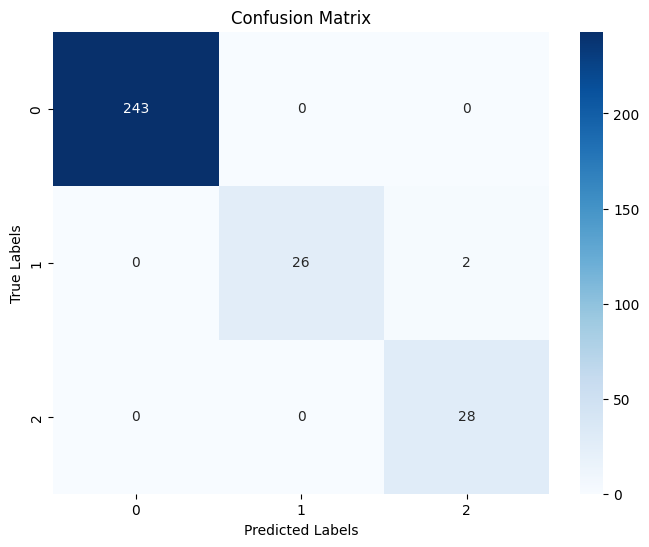

Confusion Matrix:
[[243   0   0]
 [  0  26   2]
 [  0   0  28]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      0.93      0.96        28
           2       0.93      1.00      0.97        28

    accuracy                           0.99       299
   macro avg       0.98      0.98      0.98       299
weighted avg       0.99      0.99      0.99       299



array([[243,   0,   0],
       [  0,  26,   2],
       [  0,   0,  28]])

In [36]:
try:
    model.load_weights(MODELE_NAME)
    print("\nLoaded best weights for Model evaluation.")
except Exception as e:
    print(f"\nCould not load best weights for Model: {e}. Evaluating last state.")

evaluate_model(model, history, X_val, y_val)
plot_confusion_matrix_and_report(model, X_val, y_val)

# Model test

In [18]:
# Import test dataset
df_test_format_orig = pd.read_csv(f'{path}/data/test_format.csv')
folder_test = f'{path}/data/Test'
test_data_dict = {file[:-4]: np.load(f'{folder_test}/{file}') for file in os.listdir(folder_test)}

# Preprocess data
X_test_full, _, _ = preprocess_data(test_data_dict, df_test_format_orig)

# Predict image class
preds = model.predict(X_test_full)
predicted_classes = np.argmax(preds, axis=1)

# Convert into a dataframe
df_end = pd.DataFrame(predicted_classes, columns =["target"]).reset_index().rename(columns={"index":"ID"})
df_end

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


,ID,target
0,0,1
1,1,0
2,2,1
3,3,2
4,4,0
...,...,...
115,115,1
116,116,2
117,117,0
118,118,0


In [19]:
# Export
filename = f"{path}/results/submission-4.csv"
df_end.to_csv(filename, index=False)
print(filename)

drive/MyDrive/ISEP/VUT_BUT_BRNO/Machine_Learning/results/submission-3.csv
